# Connectome manipulations & visualizations
This is the main script for connectome manipulations, which
 - applies a single or a sequence of manipulations to the connectome, as specified in the config
 - runs a structural and topological comparison of the raw and manipulated connectomes, producing visualizations as specified

In [1]:
# Initialization

""" Global imports """
import sys
import os.path
import numpy as np

""" Paths """
sys.path.insert(0, '../pipeline/')
sys.path.insert(0, '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/')

""" Local imports """
from connectome_manipulation import connectome_manipulation
from connectome_comparison import structural_comparator
from model_building import model_building
from topological_sampling.pipeline.gen_topo_db import gen_topo_db
from topological_comparator.pipeline import prepare_pipeline
from topological_comparator.pipeline.additional_stats import add_additional_stats
from topological_comparator.pipeline.contract_db import contract_db
from topological_comparator.pipeline.extract_connectivity import extract_connectivity_sonata
from topological_comparator.bin import compare_topo_db

In [2]:
# Connectome manipulation - Configuration
manip_config = {}

""" Circuit (base path) """
# manip_config['circuit_path'] = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build'
manip_config['circuit_path'] = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
# manip_config['circuit_path'] = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/sscx-white-matter'
circuit_name = os.path.split(manip_config['circuit_path'])[1]

""" General settings """
manip_config['seed'] = 3210
manip_config['N_split_nodes'] = 1

""" Manipulation (name + sequence of manipulation functions with arguments) """
# manip_config['manip'] = {'name': 'NoManip', 'fcts': [{'source': 'no_manipulation', 'kwargs': {}}]} # Just for testing

# manip_config['manip'] = {'name': 'RemoveAllSynToL5', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'Layer5', 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnToL5', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'Layer5', 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'Remove50pctAllSyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllConn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0}}]}

# manip_config['manip'] = {'name': 'RemoveAllConnWith1To10Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 1, 'max_syn_per_conn': 10}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnWith5To10Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 5, 'max_syn_per_conn': 10}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnWithOver20Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 21}}]}
# manip_config['manip'] = {'name': 'RemoveAllConnExcept5To10Syn', 'fcts': [{'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'max_syn_per_conn': 4}},
#                                                                          {'source': 'conn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'min_syn_per_conn': 11}}]}

# manip_config['manip'] = {'name': 'Remove50pctAllSyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllSynKeepGsyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0, 'keep_gsyn': True}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllSynKeepConn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0, 'keep_conns': True}}]}
# manip_config['manip'] = {'name': 'Remove50pctAllSynKeepConnKeepGsyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 50.0, 'keep_conns': True, 'keep_gsyn': True}}]}
# manip_config['manip'] = {'name': 'RemoveAllSynKeepConn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True}}]}
# manip_config['manip'] = {'name': 'RemoveAllSynKeepConnKeepGsyn', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True, 'keep_gsyn': True}}]}
manip_config['manip'] = {'name': 'ReduceToPointNeuronModel', 'fcts': [{'source': 'syn_removal', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True, 'keep_gsyn': True}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
                                                                      {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_offset', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

#manip_config['manip'] = {'name': 'SubsampleSyn10pct', 'fcts': [{'source': 'syn_subsampling', 'kwargs': {'keep_pct': 10.0}}]}

# manip_config['manip'] = {'name': 'RewireAxonsL4PC-L5PC', 'fcts': [{'source': 'axon_rewiring', 'kwargs': {'sel_grp1': {'mtype': ['L4_TPC', 'L4_UPC']}, 'sel_grp2': {'mtype': ['L5_TPC:A', 'L5_TPC:B', 'L5_TPC:C', 'L5_UPC']}, 'R': 100.0, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ShuffleAxonsL4TPC', 'fcts': [{'source': 'axon_shuffling', 'kwargs': {'sel_grp': {'mtype': 'L4_TPC'}, 'R': 100.0, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ShuffleAxonsL456EXC', 'fcts': [{'source': 'axon_shuffling', 'kwargs': {'sel_grp': {'layer': [4, 5, 6], 'synapse_class': 'EXC'}, 'R': 100.0, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ScaleNrrpX2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'n_rrp_vesicles', 'new_value': {'mode': 'scale', 'factor': 2}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsynX2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 2}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsynX0.5', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.5}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleDelayX2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'delay', 'new_value': {'mode': 'scale', 'factor': 2}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleDelayX0.5', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'delay', 'new_value': {'mode': 'scale', 'factor': 0.5}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ScaleGsyn0p1L4aff', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'Layer4', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn0p1L4eff', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'Layer4', 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn0p1ExcV1', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_filter': {'syn_type_id': list(range(100, 200))}, 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn0p1ExcV2', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': {'synapse_class': 'EXC'}, 'sel_dest': 'All', 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 0.1}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ScaleGsyn2p0L4Exc-L4Exc', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': {'layer': 4, 'synapse_class': 'EXC'}, 'sel_dest': {'layer': 4, 'synapse_class': 'EXC'}, 'syn_prop': 'conductance', 'new_value': {'mode': 'scale', 'factor': 2.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPreSynPos', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPreSynSect', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPreSynSegm', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_offset', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynPos', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_center_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_center_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_center_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_surface_x', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_surface_y', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                              {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_surface_z', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynSect', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                               {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}},
#                                                               {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynSegm', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}},
#                                                               {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_segment_offset', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ResetPostSynSectId', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_id', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ResetPostSynSectPos', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_pos', 'new_value': {'mode': 'setval', 'value': 0.0}, 'amount_pct': 100.0}}]}
# manip_config['manip'] = {'name': 'ResetPostSynSectType', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'afferent_section_type', 'new_value': {'mode': 'setval', 'value': 0}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'InvalPreSynAll', 'fcts': [{'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_x', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_y', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_center_z', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_x', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_y', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_surface_z', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_id', 'new_value': {'mode': 'setval', 'value': -1}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_pos', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_section_type', 'new_value': {'mode': 'setval', 'value': -1}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_id', 'new_value': {'mode': 'setval', 'value': -1}, 'amount_pct': 100.0}},
#                                                             {'source': 'syn_prop_alteration', 'kwargs': {'sel_src': 'All', 'sel_dest': 'All', 'syn_prop': 'efferent_segment_offset', 'new_value': {'mode': 'setval', 'value': np.nan}, 'amount_pct': 100.0}}]}

# manip_config['manip'] = {'name': 'ShuffleExc', 'fcts': [{'source': 'axon_shuffling', 'kwargs': {'sel_grp': 'Excitatory', 'R': np.inf, 'amount_pct': 100.0}}]}

# Connectome manipulation - Apply manipulation
connectome_manipulation.main(manip_config, do_profiling=True)


PROFILING: 
************************************
* RESOURCE PROFILING [initial]     *
************************************
* Max. memory usage (GB):    0.121 *
************************************

INFO: Loading circuit from /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config.json (N_split=1)
INFO: Split 1/1: Loaded 568717 synapses with 35 properties between 5924 neurons
PROFILING: 
************************************
* RESOURCE PROFILING [loaded-1/1]  *
************************************
* Max. memory usage (GB):    0.215 *
* Max. memory diff. (GB):    0.095 *
************************************
* Total time (s):            1.470 *
* Elapsed time (s):          1.470 *
************************************

INFO: APPLYING MANIPULATION "ReduceToPointNeuronModel"
INFO: >>Step 1 of 6: source=syn_removal, kwargs={'sel_src': 'All', 'sel_dest': 'All', 'amount_pct': 100.0, 'keep_conns': True, 'keep_gsyn': True}
INFO: Removing 445081 (100.0%) of 4450

INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config.json
  /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config_ReduceToPointNeuronModel.json
INFO: Preparing "conn_per_layer" plot(s)...
INFO: Loading results from ../working_dir/structural_comparator/circuit-build-S1_v1/data/Raw_conn_per_layer.pickle
INFO: Loading results from ../working_dir/structural_comparator/circuit-build-S1_v1/data/ReduceToPointNeuronModel_conn_per_layer.pickle
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-conn_per_layer-nsyn_conn.pdf...


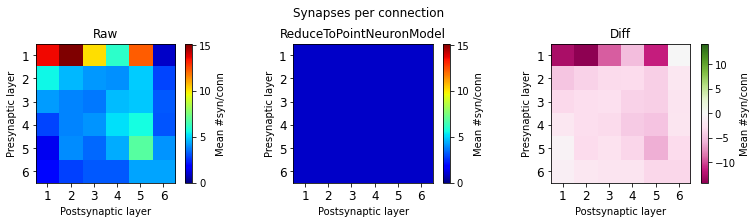

INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-conn_per_layer-conn_prob.pdf...


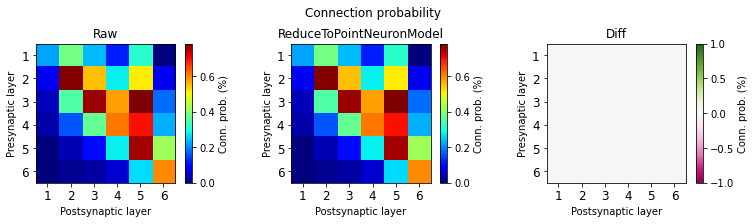

INFO: Preparing "syn_props_per_layer" plot(s)...
INFO: Loading results from ../working_dir/structural_comparator/circuit-build-S1_v1/data/Raw_syn_props_per_layer.pickle
INFO: Loading results from ../working_dir/structural_comparator/circuit-build-S1_v1/data/ReduceToPointNeuronModel_syn_props_per_layer.pickle
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-syn_props_per_layer-conductance.pdf...


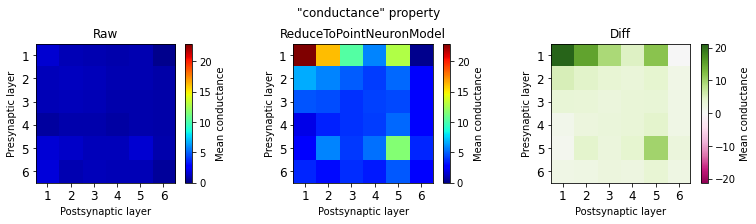

INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-syn_props_per_layer-afferent_section_id.pdf...


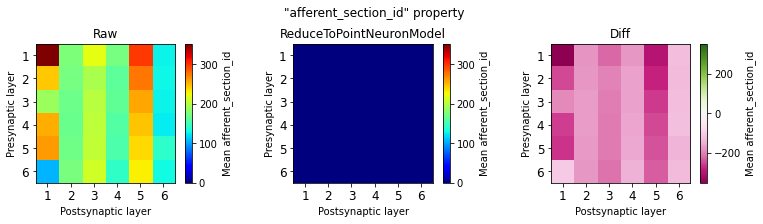

INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_ReduceToPointNeuronModel/struct_comp-syn_props_per_layer-afferent_section_pos.pdf...


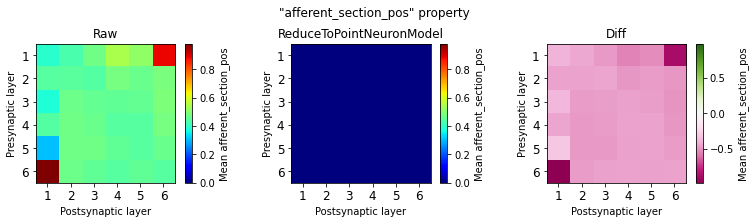

In [3]:
## Structural comparison of connectomes - Configuration
structcomp_config = {}

""" General settings """
structcomp_config['working_dir'] = os.path.join('..', 'working_dir', 'structural_comparator', circuit_name)
structcomp_config['out_dir'] = os.path.join('figures', circuit_name)

""" Types of structural plots """
# structcomp_config['plot_types'] = [{'name': 'inh_adjacency',
#                                     'fct': {'source': 'adjacency', 'kwargs': {'nrn_filter': {'synapse_class': 'INH'}}},
#                                     'res_sel': ['adj', 'adj_cnt'],
#                                     'range_prctile': 95,
#                                     'fig_size': (11, 3),
#                                     'fig_file': {'format': 'png', 'dpi': 600}}]

# structcomp_config['plot_types'] = [{'name': 'exc_conn_per_layer',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'layer', 'nrn_filter': {'synapse_class': 'EXC'}}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'exc_inh_conn',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'synapse_class'}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'overall_conn',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': None}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'exc_syn_props_per_layer',
#                                     'fct': {'source': 'properties', 'kwargs': {'group_by': 'layer', 'nrn_filter': {'synapse_class': 'EXC'}}},
#                                     'res_sel': ['conductance', 'delay', 'afferent_section_id', 'afferent_section_pos'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'syn_props_per_layer',
#                                     'fct': {'source': 'properties', 'kwargs': {'group_by': 'layer'}},
#                                     'res_sel': ['conductance', 'delay', 'afferent_section_id', 'afferent_section_pos'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)},
#                                    {'name': 'syn_props_per_mtype',
#                                     'fct': {'source': 'properties', 'kwargs': {'group_by': 'mtype'}},
#                                     'res_sel': ['conductance', 'delay', 'afferent_section_id', 'afferent_section_pos'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)}]

# structcomp_config['plot_types'] = [{'name': 'conn_per_layer',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'layer'}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 100,
#                                     'fig_size': (11, 3)},
#                                    {'name': 'conn_per_mtype',
#                                     'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'mtype'}},
#                                     'res_sel': ['nsyn_conn', 'conn_prob'],
#                                     'range_prctile': 95,
#                                     'fig_size': (11, 3)},
#                                    {'name': 'adjacency',
#                                     'fct': {'source': 'adjacency', 'kwargs': {}},
#                                     'res_sel': ['adj', 'adj_cnt'],
#                                     'range_prctile': 95,
#                                     'fig_size': (11, 3),
#                                     'fig_file': {'format': 'png', 'dpi': 600}}]

structcomp_config['plot_types'] = [{'name': 'conn_per_layer',
                                    'fct': {'source': 'connectivity', 'kwargs': {'group_by': 'layer'}},
                                    'res_sel': ['nsyn_conn', 'conn_prob'],
                                    'range_prctile': 100,
                                    'fig_size': (11, 3)},
                                   {'name': 'syn_props_per_layer',
                                    'fct': {'source': 'properties', 'kwargs': {'group_by': 'layer', 'fct': 'np.mean'}},
                                    'res_sel': ['conductance', 'afferent_section_id', 'afferent_section_pos'],
                                    'range_prctile': 100,
                                    'fig_size': (11, 3)}]

""" Circuits to compare """
structcomp_config['circuits'] = {'0': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', 'circuit_config.json'),
                                       'circuit_name': 'Raw'},
                                 '1': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', f'circuit_config_{manip_config["manip"]["name"]}.json'),
                                       'circuit_name': manip_config['manip']['name']}}

# Structural comparison of connectomes - Run comparison
structural_comparator.main(structcomp_config, True, force_recomp=False)

In [4]:
# Topological comparison of connectomes - Configuration
topocomp_config = {}

""" General settings """
topocomp_config['working_dir'] = os.path.join('..', 'working_dir', 'topological_comparator', circuit_name)
topocomp_config['out_dir'] = os.path.join('figures', circuit_name)

""" Circuits to compare """
topocomp_config['circuits'] = {'0': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', 'circuit_config.json'),
                                     'circuit_name': 'Raw'},
                               '1': {'circuit_config': os.path.join(manip_config['circuit_path'], 'sonata', f'circuit_config_{manip_config["manip"]["name"]}.json'),
                                     'circuit_name': manip_config["manip"]["name"]}}

# Topological comparison of connectomes - Prepare topological database
topocomp_force_recomp = False
topocomp_config_files = {}
for cidx in sorted(topocomp_config['circuits'].keys()):
    wrkdir = os.path.join(topocomp_config['working_dir'], topocomp_config['circuits'][cidx]['circuit_name'])
    topocomp_config_files[cidx] = os.path.join(wrkdir, 'config', 'common_config.json')
    if os.path.exists(wrkdir) and not topocomp_force_recomp:
        print(f'INFO: Folder {wrkdir} already exists ... SKIPPING', flush=True)
    else:
        print(f'INFO: Preparing pipeline in {wrkdir}', flush=True)
        prepare_pipeline.prepare_and_place_files(topocomp_config['circuits'][cidx]['circuit_config'], 'All', wrkdir)
        extract_connectivity_sonata.main(topocomp_config_files[cidx])
        gen_topo_db.main(topocomp_config_files[cidx])


INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/Raw already exists ... SKIPPING
INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/RewireAxonsL4PC-L5PC already exists ... SKIPPING


Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_RewireAxonsL4PC-L5PC/topo_comp-all_params.pdf...


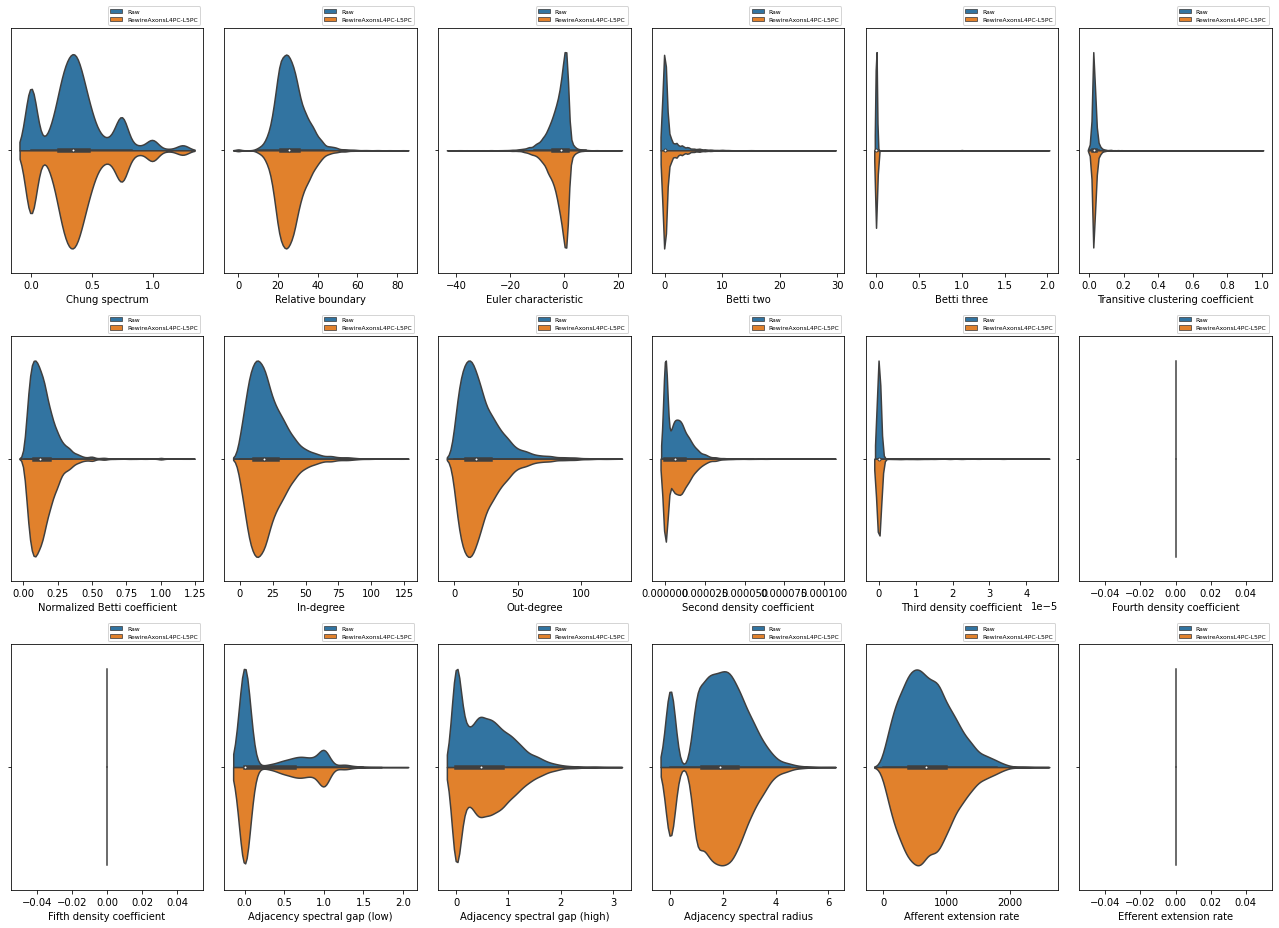

Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_RewireAxonsL4PC-L5PC/topo_comp-all_params-per_mtype.pdf...


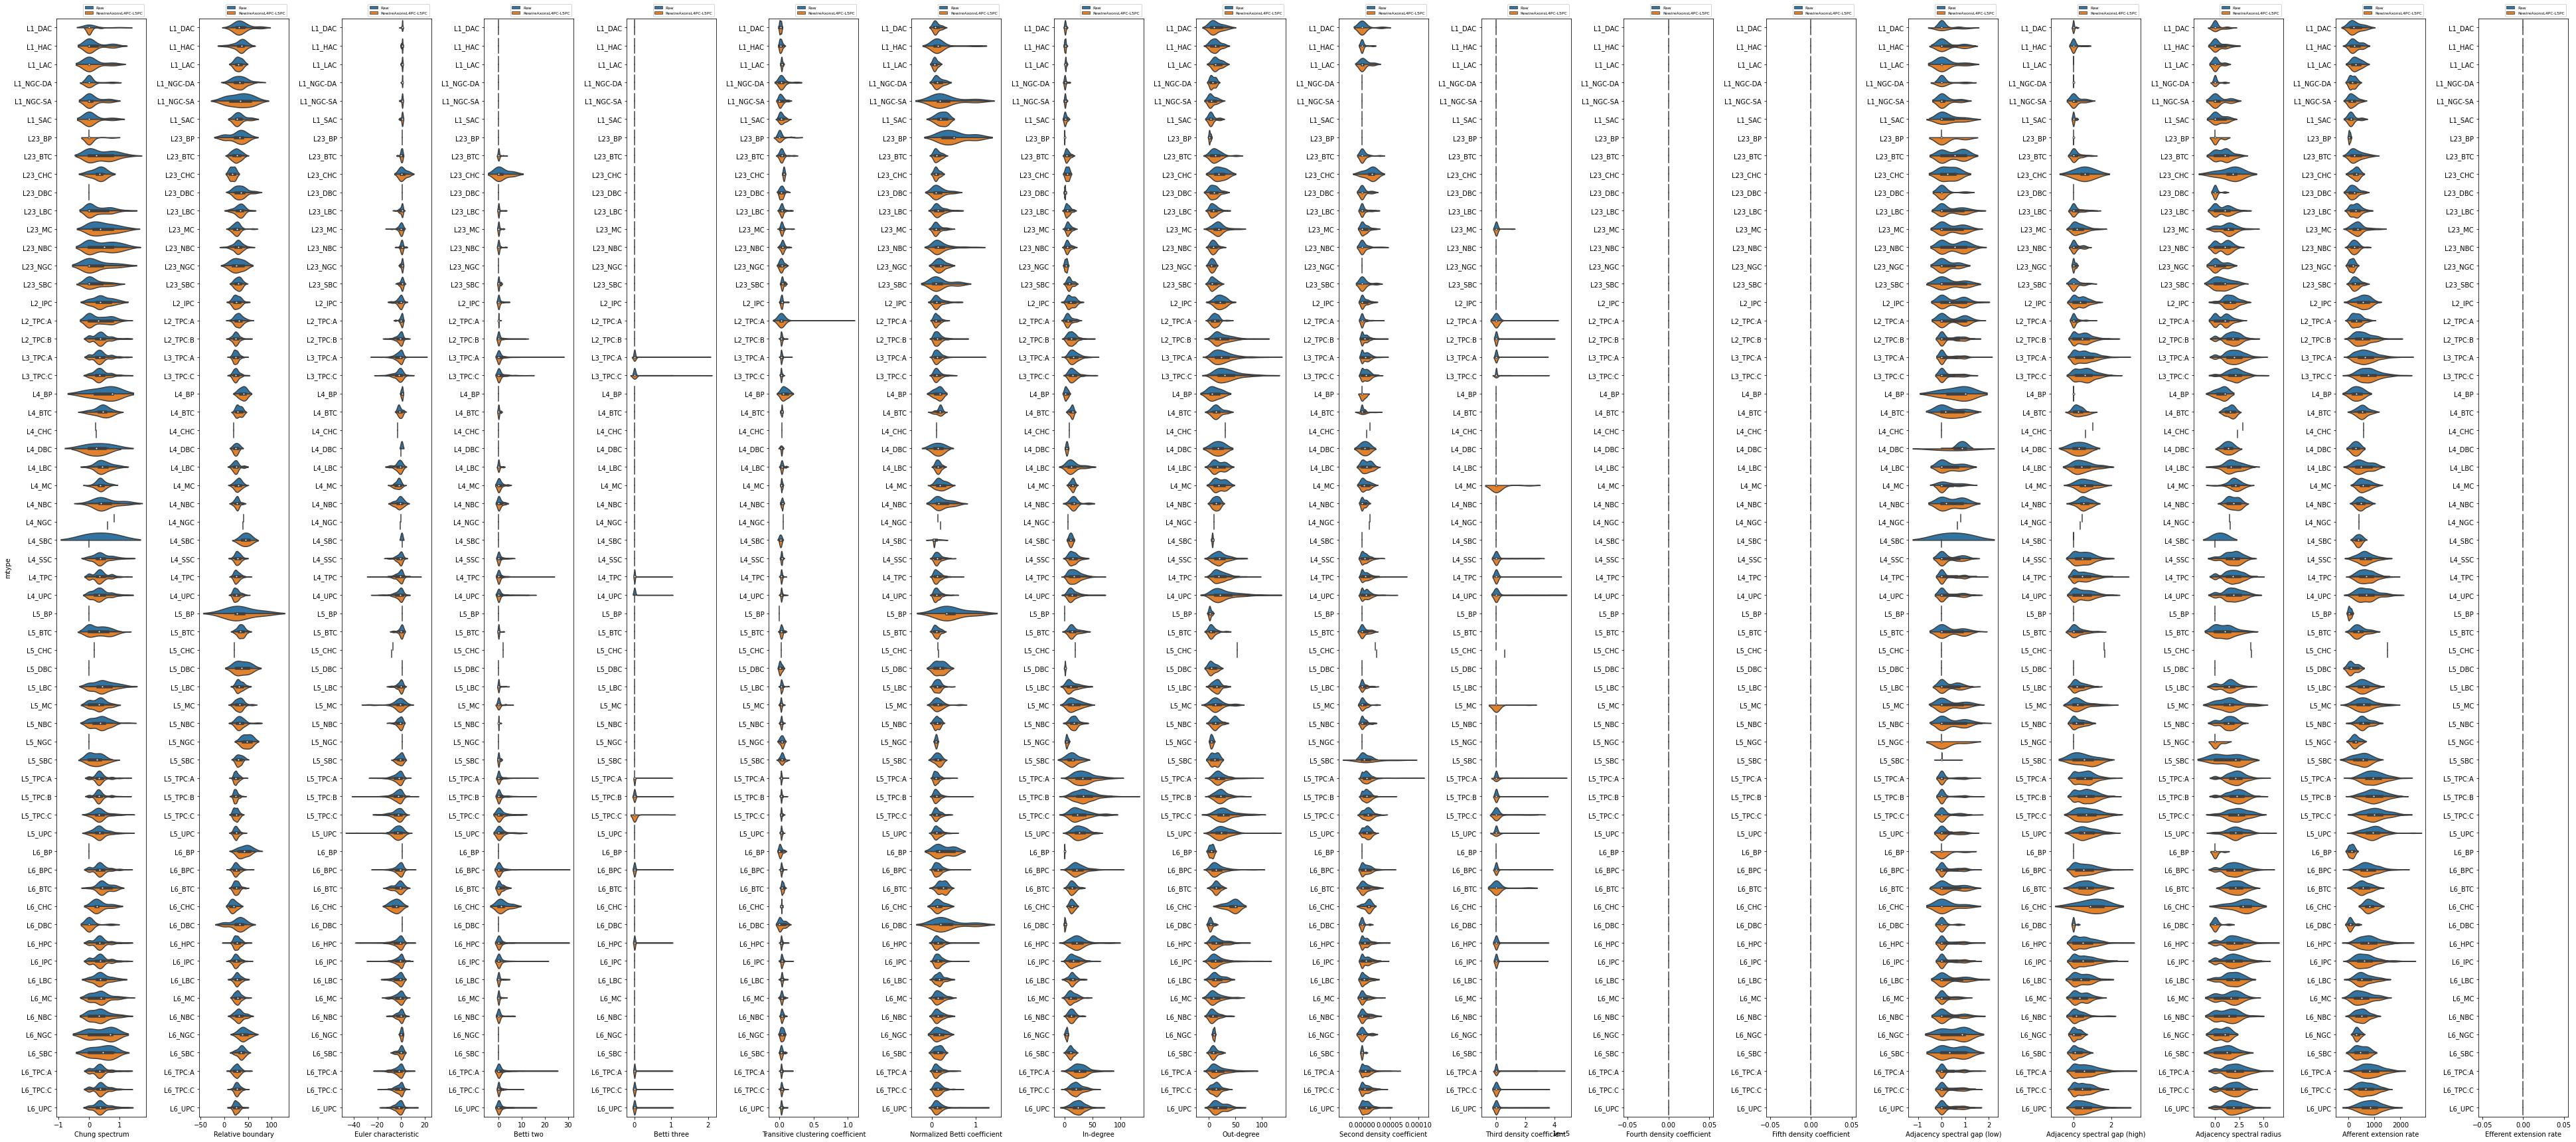

Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/connectome_manipulator/notebooks/figures/circuit-build-S1_v1/Raw_vs_RewireAxonsL4PC-L5PC/topo_comp-all_params-per_layer.pdf...


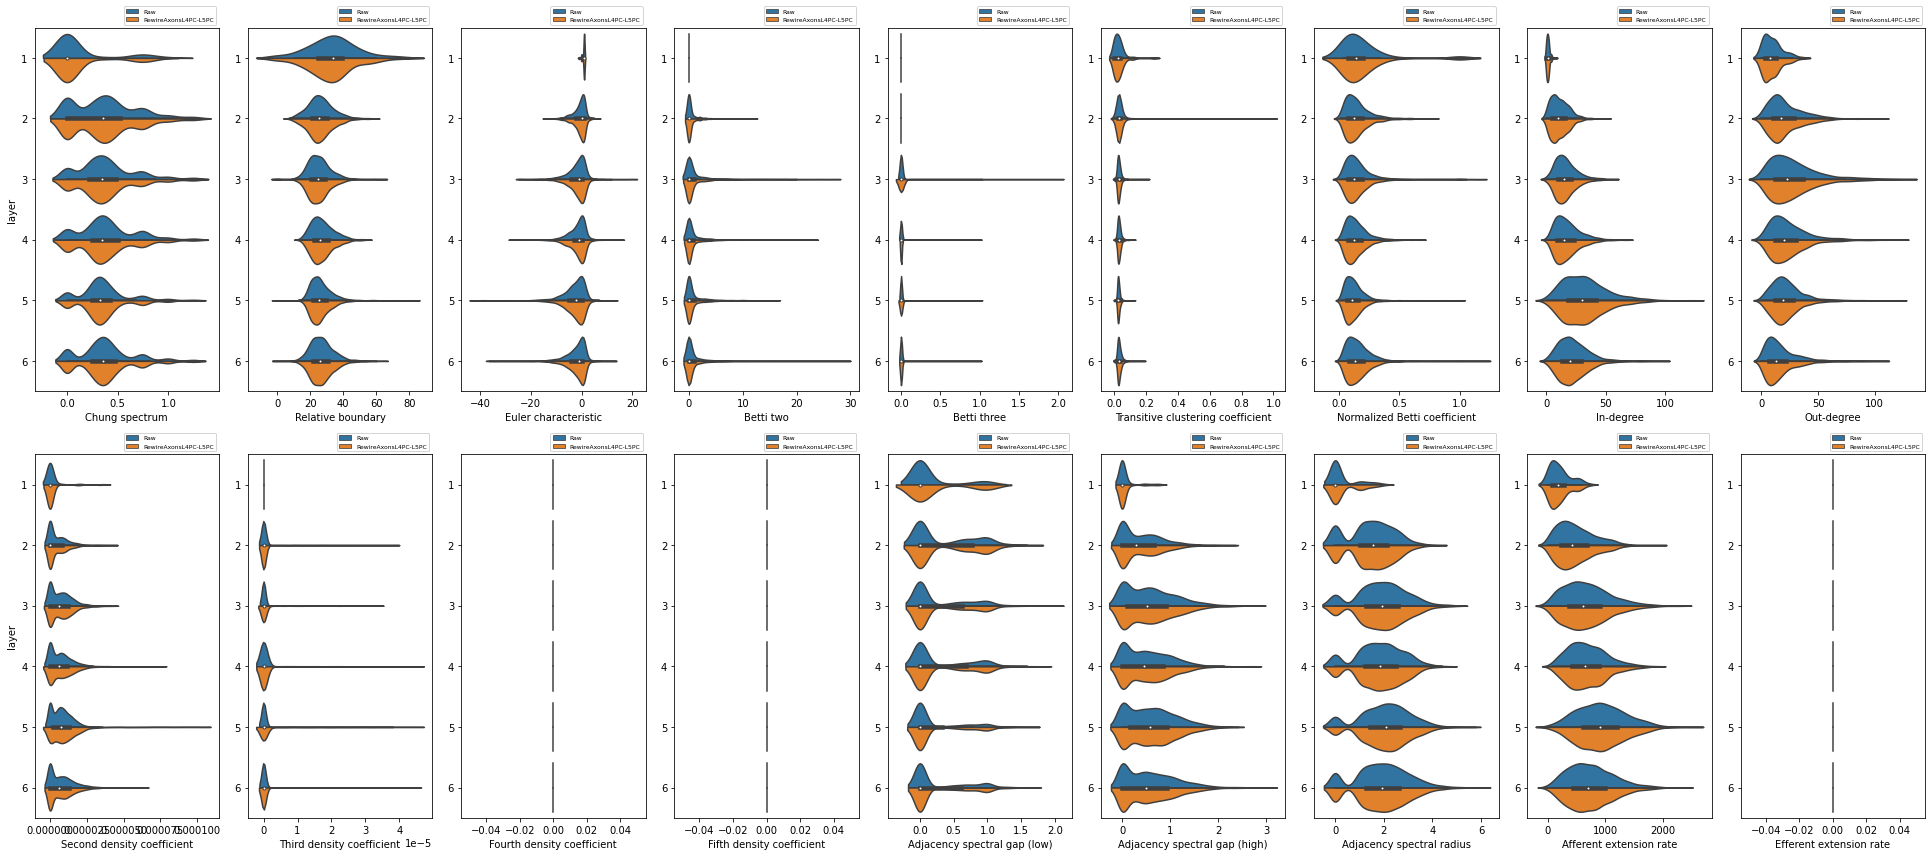

In [5]:
# Topological comparison of connectomes - Plot comparison
topocomp_db_dict, topocomp_param_dict = compare_topo_db.read_topo_dbs_and_parameter_specs({topocomp_config['circuits'][cidx]['circuit_name']: topocomp_config_files[cidx] for cidx in sorted(topocomp_config_files.keys())})
compare_topo_db.plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, '', topocomp_config['out_dir'], num_rows=3, show_fig=True)
compare_topo_db.plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, 'mtype', topocomp_config['out_dir'], num_rows=1, show_fig=True)
compare_topo_db.plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, 'layer', topocomp_config['out_dir'], num_rows=2, show_fig=True)


In [ ]:
assert False, 'STOP HERE'

In [3]:
### ACCESS EDGE TABLE (DEVELOPMENT)
from bluepysnap.circuit import Circuit
from bluepysnap.sonata_constants import Node
from bluepysnap.sonata_constants import Edge

circuit_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
circuit_name = os.path.split(circuit_path)[-1]
sonata_config =  os.path.join(circuit_path, 'sonata', 'circuit_config.json') # [Using default name]
# sonata_config =  os.path.join(manip_config['circuit_path'], 'sonata', 'circuit_config.json') # [Using default name]
c = Circuit(sonata_config)
nodes = c.nodes['All']
node_ids = nodes.ids()
edges = c.edges['default']
edges_table = edges.afferent_edges(node_ids, properties=sorted(edges.property_names))
circuit = c

INFO: Circuit loaded: /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config.json
INFO: Loading data from ../working_dir/model_building/circuit-build-S1_v1/data/ConnProb4thOrder.pickle
INFO: Running order-4 model building...
OFFSET MODEL FIT: f(dx, dy, dz) ~ RandomForestRegressor(n_estimators=500, random_state=0)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
<TIME ELAPSED (model building): 6.8s>
INFO: Writing model to ../working_dir/model_building/circuit-build-S1_v1/model/ConnProb4thOrder.pickle
INFO: Running order-4 data/model visualization...
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/co

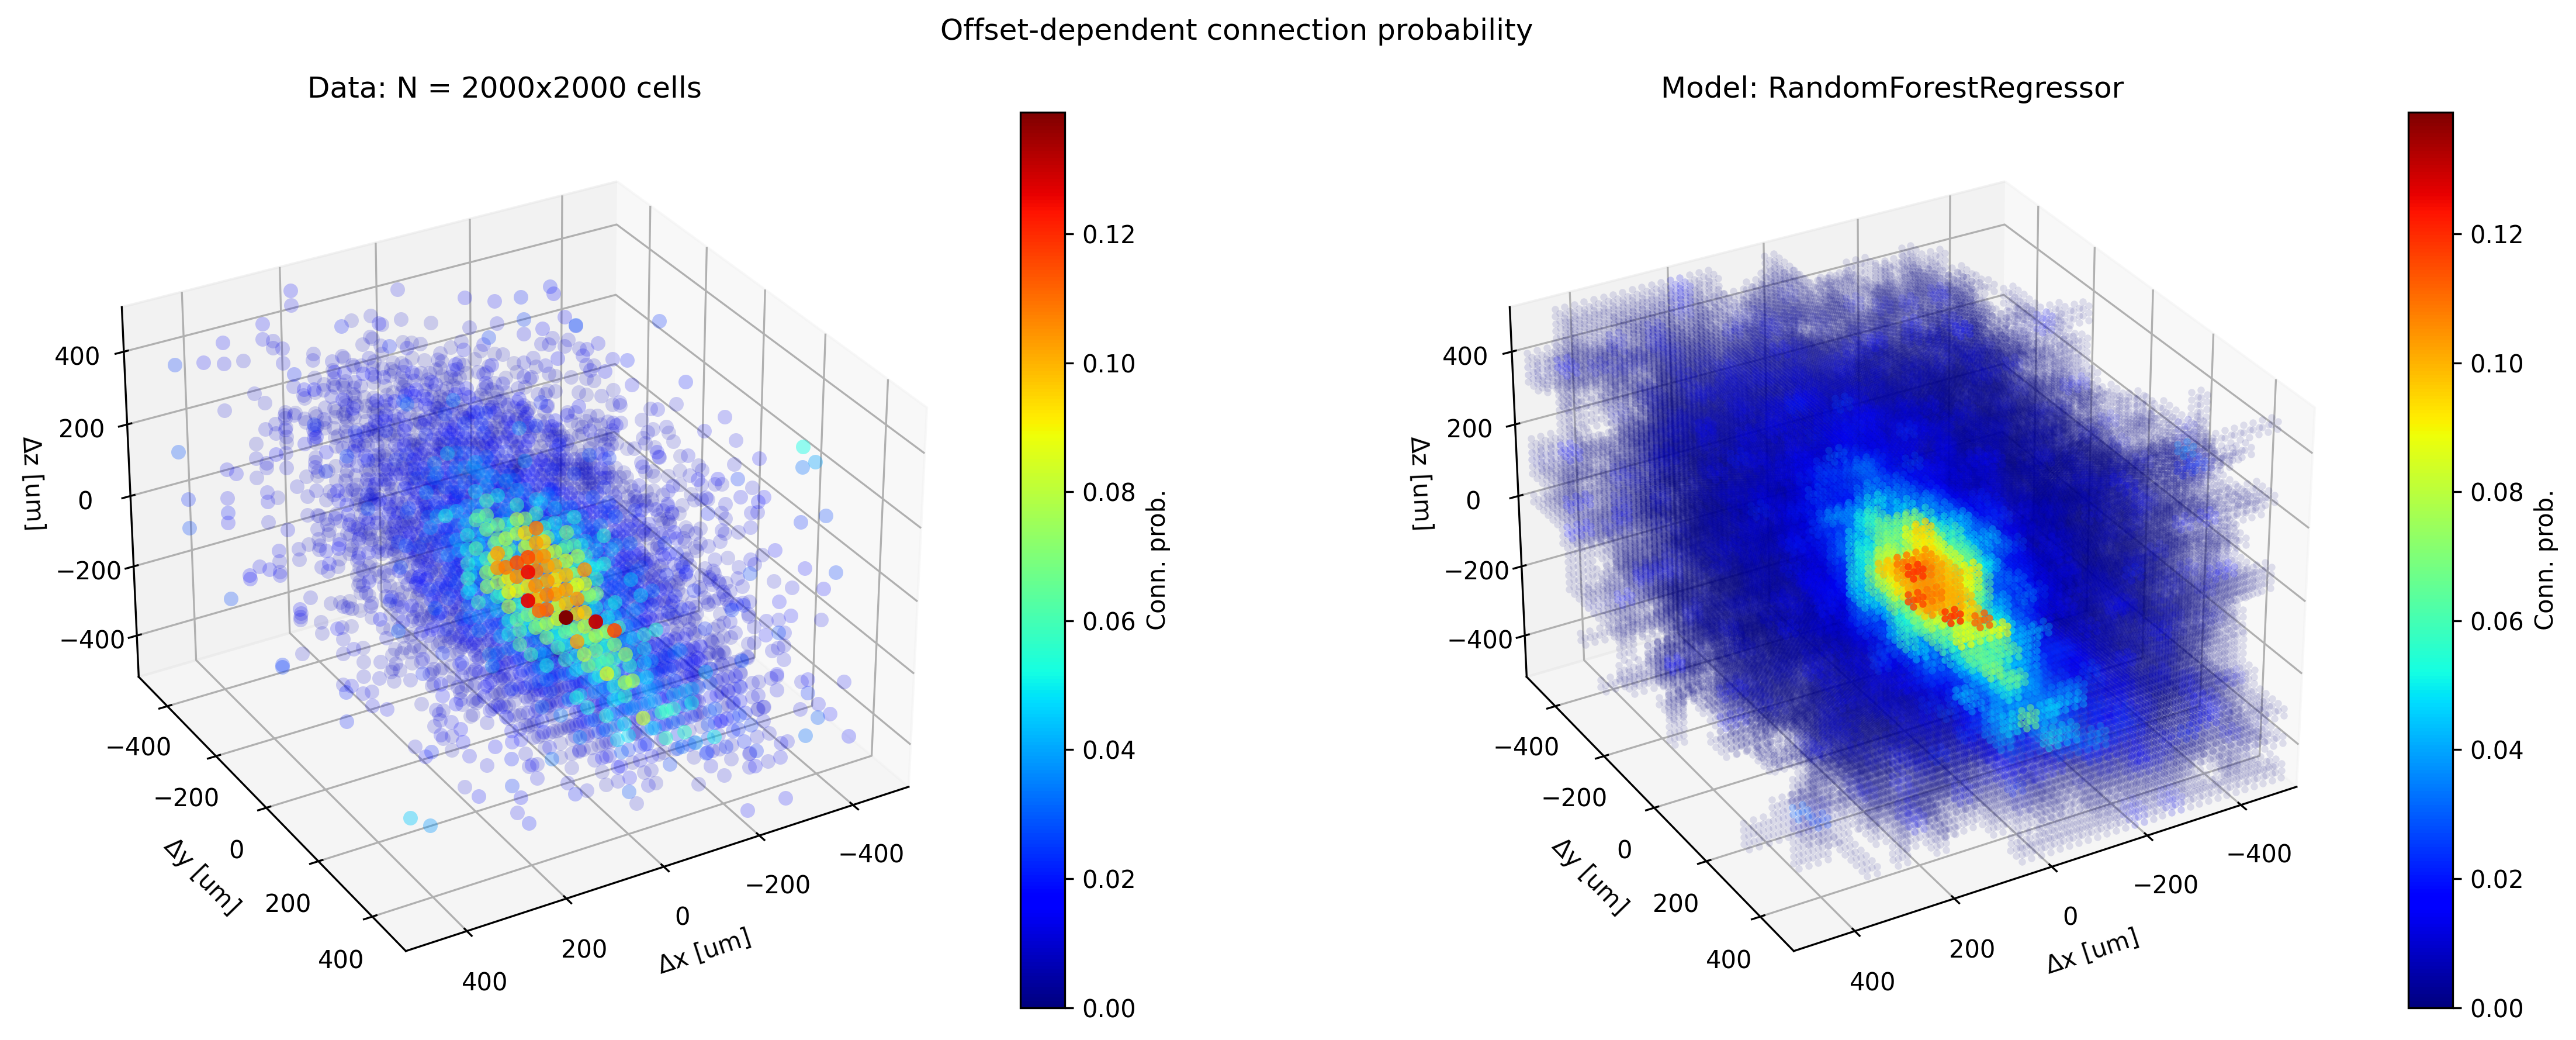

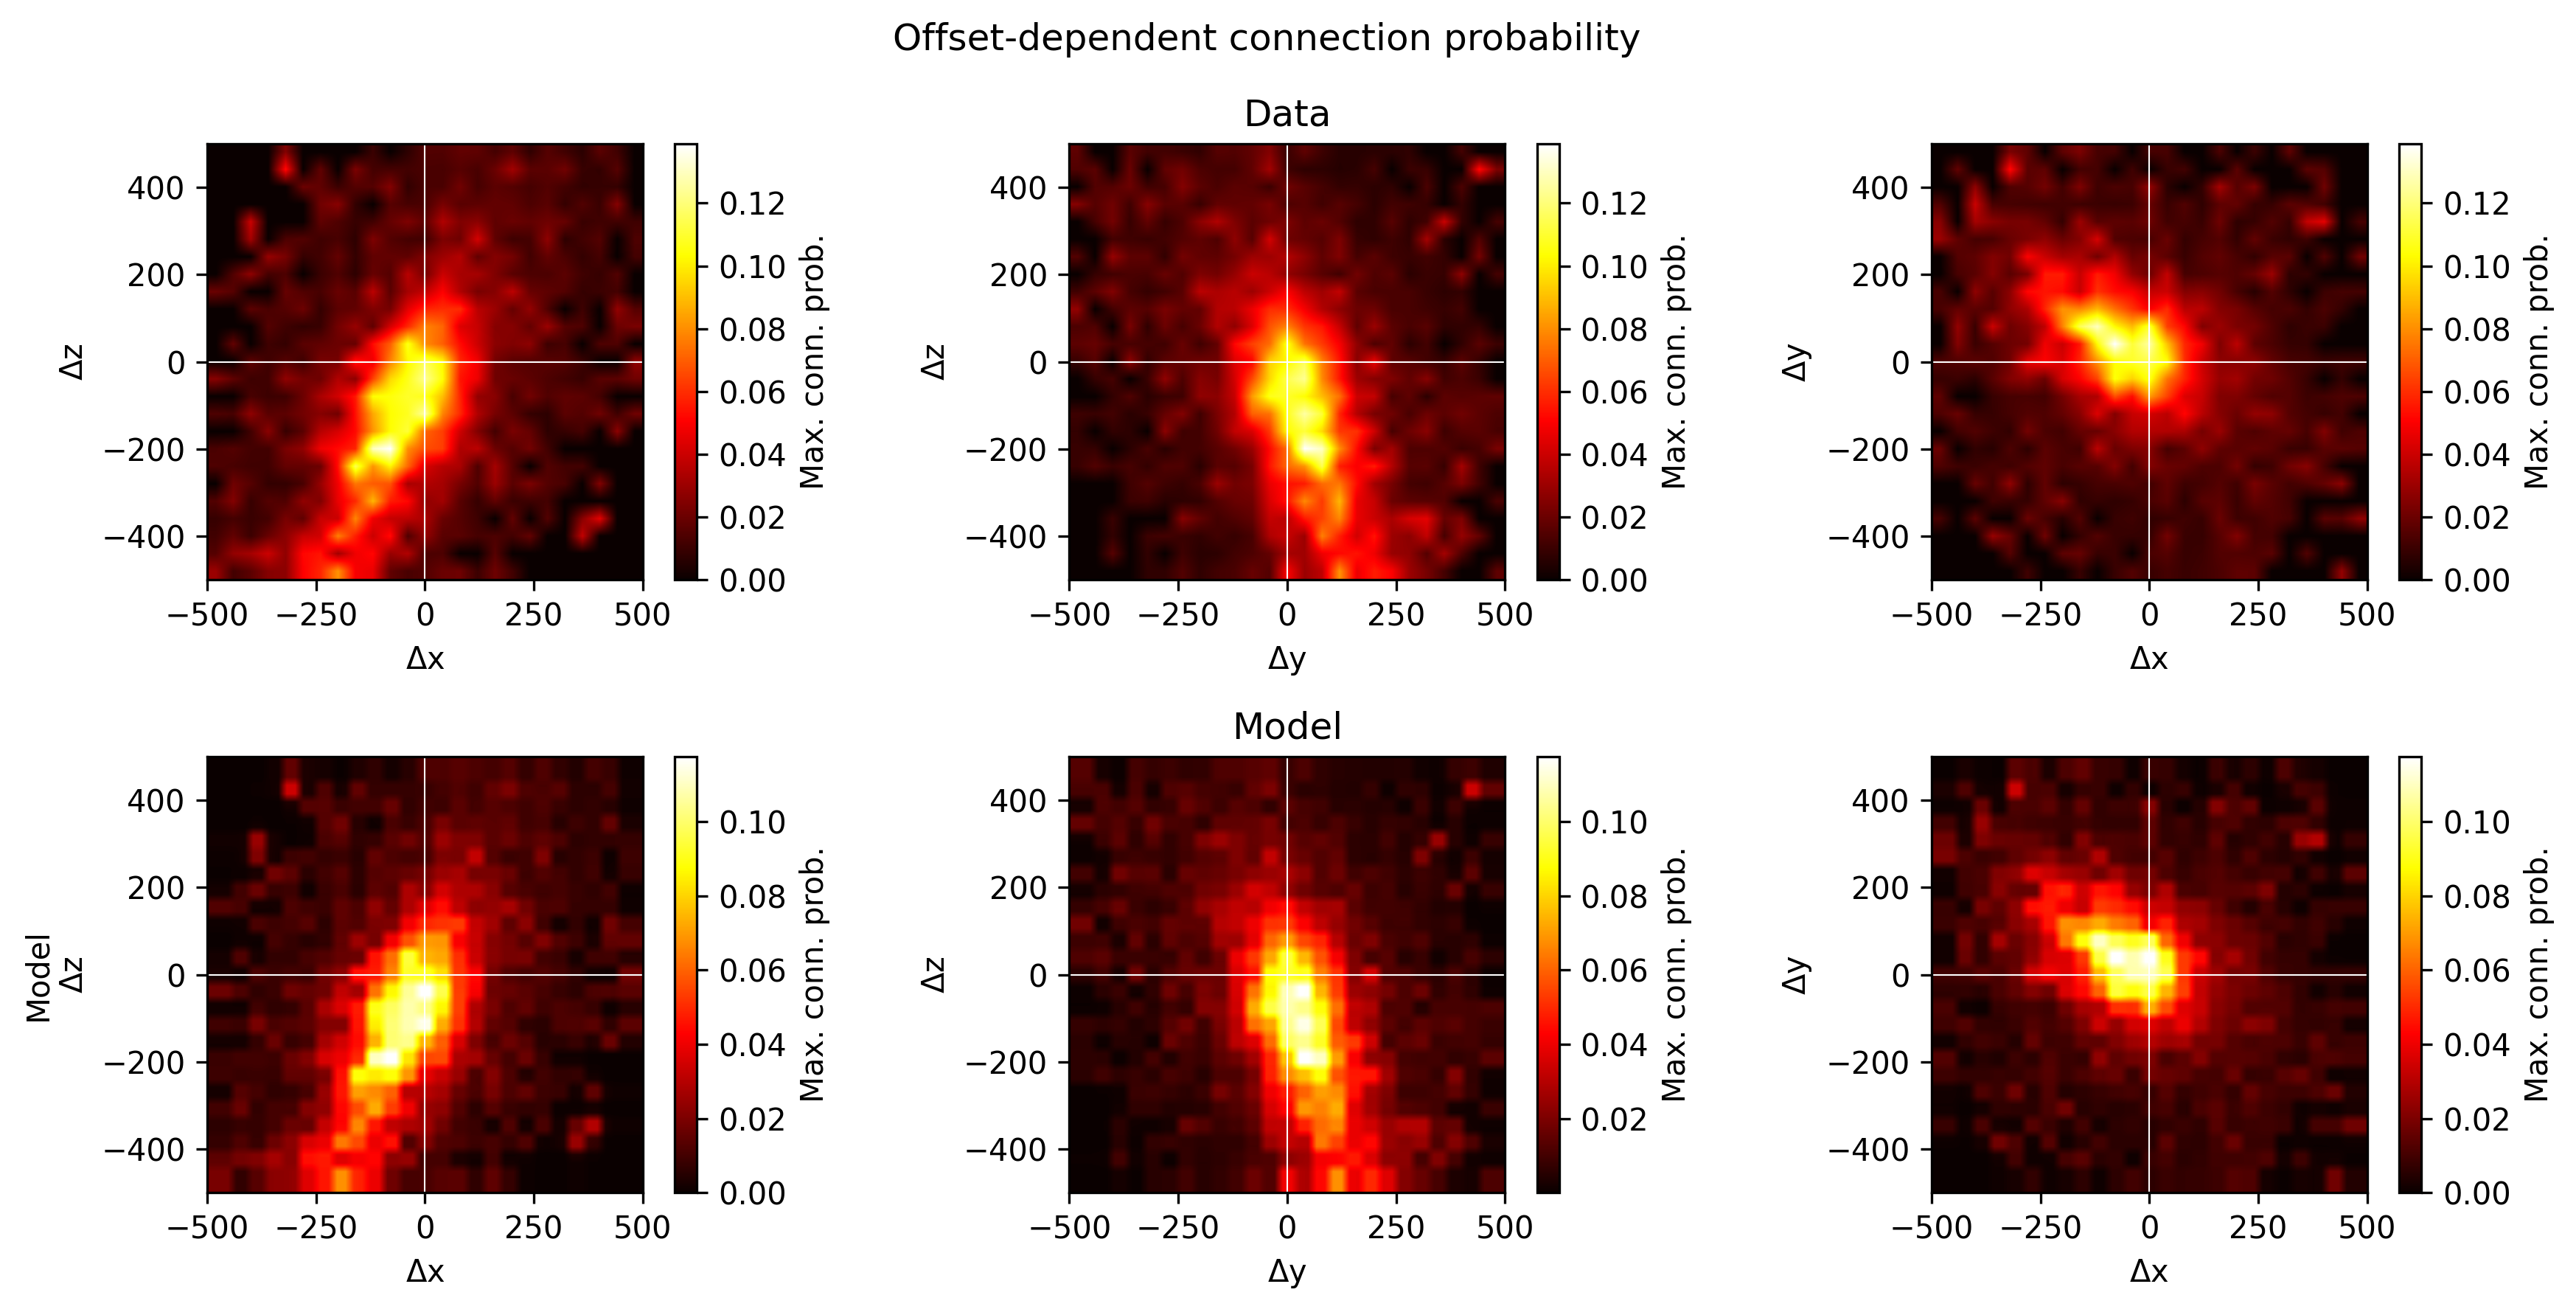

In [7]:
# Model building - Configuration
circuit_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
circuit_name = os.path.split(circuit_path)[-1]

model_config = {}

""" General settings """
model_config['working_dir'] = os.path.join('..', 'working_dir', 'model_building', circuit_name)
model_config['out_dir'] = os.path.join('figures', circuit_name)
model_config['seed'] = 7531

""" Model specifications """
model_config['circuit_config'] = os.path.join(circuit_path, 'sonata', 'circuit_config.json')
# model_config['model'] = {'name': 'DistDepDelay', 'fct': {'source': 'delay', 'kwargs': {'sample_size': 1000, 'bin_size_um': 100, 'max_range_um': None}}}
# model_config['model'] = {'name': 'ConnProb1stOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 1, 'sample_size': 1000}}}
# model_config['model'] = {'name': 'ConnProb2ndOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 2, 'sample_size': 1000, 'bin_size_um': 100, 'max_range_um': None}}}
# model_config['model'] = {'name': 'ConnProb3rdOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 3, 'sample_size': 1000, 'bin_size_um': 100, 'max_range_um': None}}}
model_config['model'] = {'name': 'ConnProb4thOrder', 'fct': {'source': 'conn_prob', 'kwargs': {'order': 4, 'sample_size': 2000, 'bin_size_um': 40, 'max_range_um': 500, 'n_estimators': 500, 'max_depth': None}}}

# Model building - Run
model_building.main(model_config, True, force_recomp=False)